In this HW, you will finetune a stable diffusion model to enable it generate images from Naruto.

You job is to load a pretrained stable diffusion model (i.e. all its compenents: vae, unet, text encoder, text tokenizer and schedule) and then finetune it on the text-to-naruto dataset.

Finally, generate and show 10 generations. Use 5 prompts from the dataset itself and write 5 prompts yourself.

**Hints:**
- Resize the image to (512,512)
- Use appropriate data transformations and augmentations.
- If you get out of memory error, use a smaller batch size.
- You might want to use the [PNDMScheduler](https://huggingface.co/docs/diffusers/en/api/schedulers/pndm). It works better.
- At inferece time, set the training steps to 100.
- You can have a look [here](https://huggingface.co/docs/diffusers/main/en/tutorials/basic_training) and [here](https://huggingface.co/blog/stable_diffusion) to see how to do training with diffusers and use stable diffusion models.

**Disclaimer!** You cannot use the training or finetuning scripts from diffusers as it is. You have to write the code yourself. You can have a look at them though to see what needs to be done.

Finally, Stable diffusion is a large model and the Colab T4 GPU memory will not be enough. Use the following model. It's a smaller version of stable diffusion.

# import libs

In [2]:
! pip install diffusers
! pip install datasets
from IPython.display import clear_output
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from diffusers import StableDiffusionPipeline, PNDMScheduler
from datasets import load_dataset
from PIL import Image
import requests
from io import BytesIO
from tqdm import tqdm
clear_output()

# Data Handling

In [3]:
dataset = load_dataset("lambdalabs/naruto-blip-captions")

class CustomDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = item['image']
        caption = item['text']

        if self.transform:
            image = self.transform(image)

        return image, caption

transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
train_dataset = CustomDataset(dataset['train'], transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/1221 [00:00<?, ? examples/s]

# Model

In [4]:
model_id = "OFA-Sys/small-stable-diffusion-v0"
pipeline = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32)
pipeline.scheduler = PNDMScheduler.from_config(pipeline.scheduler.config)
pipeline = pipeline.to("cuda")
clear_output()

# Finetuning

In [5]:
optimizer = torch.optim.AdamW(pipeline.unet.parameters(), lr=1e-5)
pipeline.unet.train()
num_epochs = 10

*The reason for the scaling by 0.18215*
https://github.com/huggingface/diffusers/issues/437

In [6]:
for epoch in range(num_epochs):
    # Create a progress bar for each epoch
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for batch in progress_bar:
        images, captions = batch
        images = images.to("cuda", dtype=torch.float32)

        # Text embeddings
        text_inputs = pipeline.tokenizer(captions, padding="max_length", max_length=pipeline.tokenizer.model_max_length, truncation=True, return_tensors="pt")
        text_embeddings = pipeline.text_encoder(text_inputs.input_ids.to("cuda"))[0]

        # Targets
        latents = pipeline.vae.encode(images).latent_dist.sample()
        latents = latents * 0.18215

        # Sample noise that we'll add to the latents
        noise = torch.randn_like(latents)
        batch_size = latents.shape[0]
        # Sample a random timestep for each image
        timesteps = torch.randint(0, pipeline.scheduler.num_train_timesteps, (batch_size,), device=latents.device).long()

        # Add noise to the latents according to the noise magnitude at each timestep
        noisy_latents = pipeline.scheduler.add_noise(latents, noise, timesteps)

        # Predict the noise residual
        noise_pred = pipeline.unet(noisy_latents, timesteps, encoder_hidden_states=text_embeddings).sample

        loss = torch.nn.functional.mse_loss(noise_pred.float(), noise.float())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Update the progress bar with the current loss
        progress_bar.set_postfix(loss=loss.item())

    print(f"Epoch {epoch+1}/{num_epochs} completed")


Epoch 1/10:   0%|          | 0/306 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'PNDMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'PNDMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Epoch 1/10: 100%|██████████| 306/306 [04:10<00:00,  1.22it/s, loss=0.0219]


Epoch 1/10 completed


Epoch 2/10: 100%|██████████| 306/306 [04:08<00:00,  1.23it/s, loss=0.0065]


Epoch 2/10 completed


Epoch 3/10: 100%|██████████| 306/306 [04:08<00:00,  1.23it/s, loss=0.158]


Epoch 3/10 completed


Epoch 4/10: 100%|██████████| 306/306 [04:08<00:00,  1.23it/s, loss=0.0268]


Epoch 4/10 completed


Epoch 5/10: 100%|██████████| 306/306 [04:08<00:00,  1.23it/s, loss=0.0861]


Epoch 5/10 completed


Epoch 6/10: 100%|██████████| 306/306 [04:08<00:00,  1.23it/s, loss=0.0186]


Epoch 6/10 completed


Epoch 7/10: 100%|██████████| 306/306 [04:09<00:00,  1.23it/s, loss=0.0132]


Epoch 7/10 completed


Epoch 8/10: 100%|██████████| 306/306 [04:08<00:00,  1.23it/s, loss=0.0893]


Epoch 8/10 completed


Epoch 9/10: 100%|██████████| 306/306 [04:08<00:00,  1.23it/s, loss=0.207]


Epoch 9/10 completed


Epoch 10/10: 100%|██████████| 306/306 [04:09<00:00,  1.22it/s, loss=0.314]

Epoch 10/10 completed


# Generation examples
Finally, generate and show 10 generations. Use 5 prompts from the dataset
itself and write 5 prompts yourself.

  0%|          | 0/100 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Generated image 1 with prompt: a man with dark hair and brown eyes


  0%|          | 0/100 [00:00<?, ?it/s]

Generated image 2 with prompt: a man in a hoodie with a fire in the background


  0%|          | 0/100 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Generated image 3 with prompt: a man with a red hair and a black shirt


  0%|          | 0/100 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Generated image 4 with prompt: a man in a blue shirt and headband


  0%|          | 0/100 [00:00<?, ?it/s]

Generated image 5 with prompt: a dog in a blue shirt laying on the ground


  0%|          | 0/100 [00:00<?, ?it/s]

Generated image 6 with prompt: A girl with pink hair


  0%|          | 0/100 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Generated image 7 with prompt: A boy with blue eyes


  0%|          | 0/100 [00:00<?, ?it/s]

Generated image 8 with prompt: A girl with red hair


  0%|          | 0/100 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


Generated image 9 with prompt: A boy with green eyes


  0%|          | 0/100 [00:00<?, ?it/s]

Generated image 10 with prompt: A boy riding a bicycle


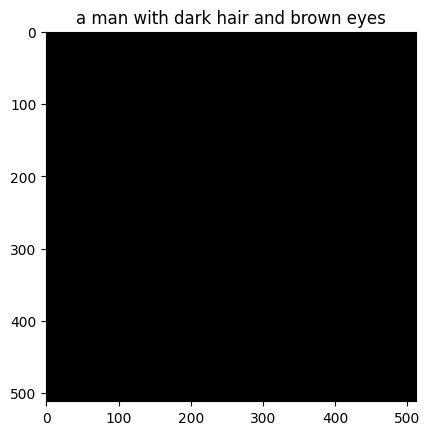

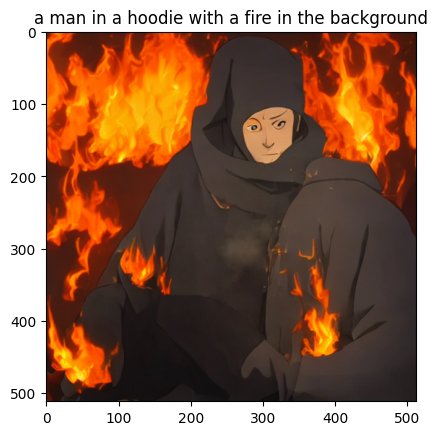

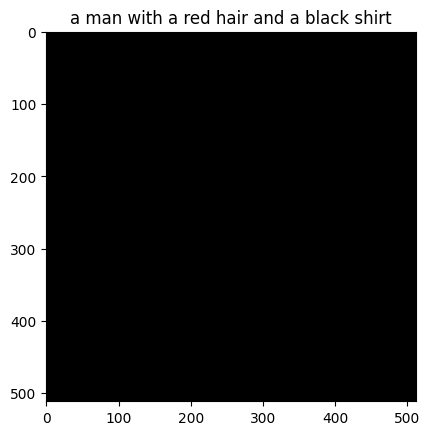

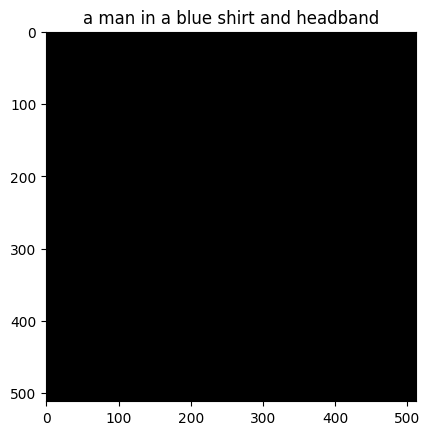

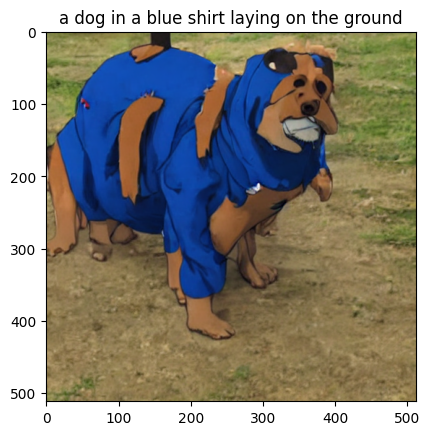

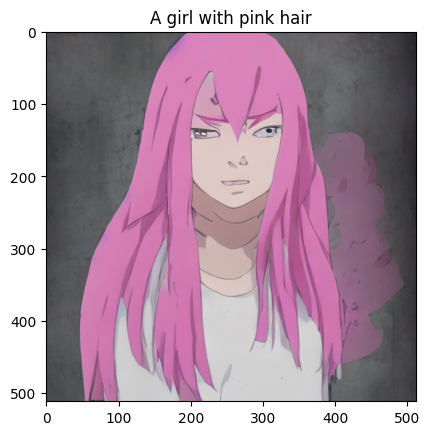

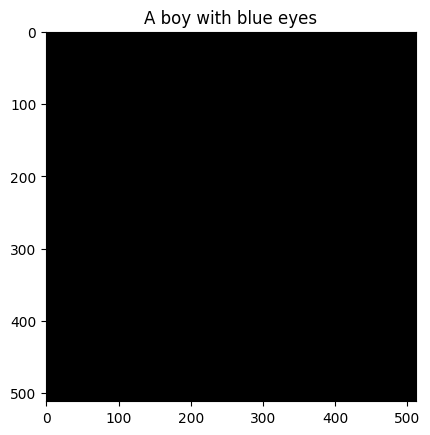

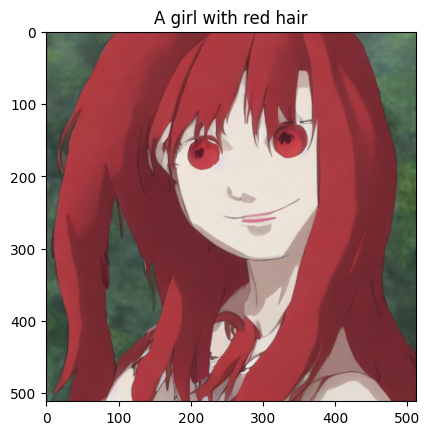

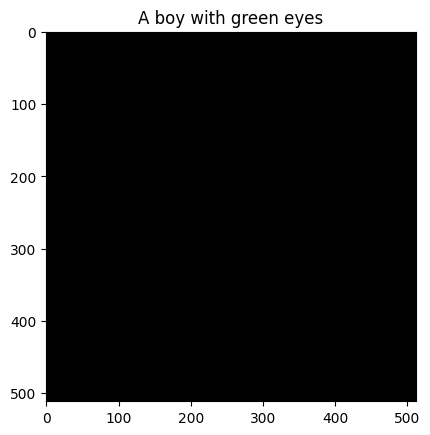

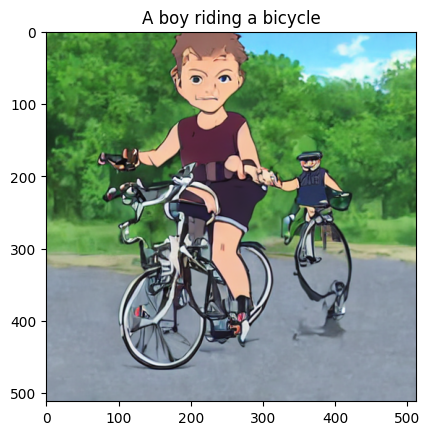

In [7]:
pipeline.unet.eval()

dataset_prompts = dataset['train'].select(range(5))['text']
my_prompts = [
    "A girl with pink hair",
    "A boy with blue eyes",
    "A girl with red hair",
    "A boy with green eyes",
    "A boy riding a bicycle"
]
all_prompts = dataset_prompts + my_prompts


for i, prompt in enumerate(all_prompts):
    image = pipeline(prompt, num_inference_steps=100).images[0]
    image.save(f"generated_image_{i+1}.png")
    print(f"Generated image {i+1} with prompt: {prompt}")

def show_image(path):
    image = Image.open(path)
    plt.imshow(image)
    plt.show()

paths = [f"generated_image_{i+1}.png" for i in range(len(all_prompts))]
for path, prompt in zip(paths, all_prompts):
    plt.title(prompt)
    show_image(path)

  0%|          | 0/100 [00:00<?, ?it/s]

Generated image 1 with prompt: Naruto


  0%|          | 0/100 [00:00<?, ?it/s]

Generated image 2 with prompt: Sasuke


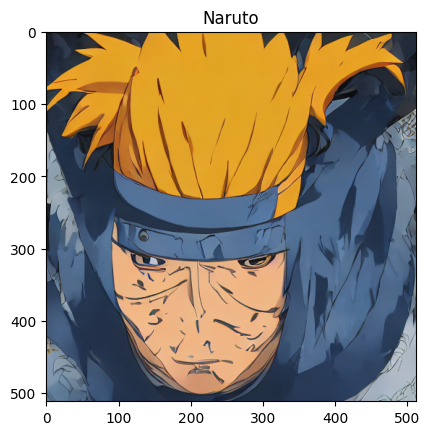

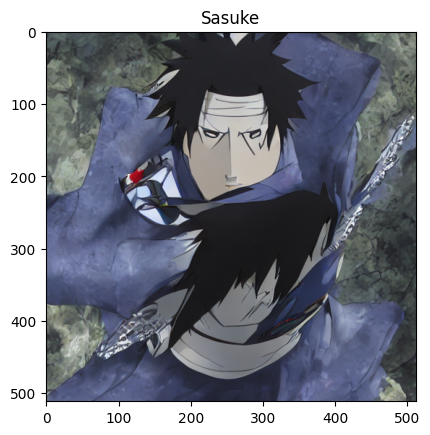

In [10]:
more_prompts = ["Naruto", "Sasuke"]
for i, prompt in enumerate(more_prompts):
    image = pipeline(prompt, num_inference_steps=100).images[0]
    image.save(f"generated_more_image_{i+1}.png")
    print(f"Generated image {i+1} with prompt: {prompt}")
paths = [f"generated_more_image_{i+1}.png" for i in range(len(more_prompts))]
for path, prompt in zip(paths, more_prompts):
    plt.title(prompt)
    show_image(path)

# Discussion
The model has many compenents such as vae, unet, text encoder, text tokenizer and schedule. However, I only finetuned the unet. Text encoder and tokenizer are already trained on large, diverse datasets and are typically good at understanding a wide range of prompts unless we have a very specific use case. Moreover, the vae might not need to be finetuned because it is for encoding and decoding images between the pixel space and the latent space, so, it's more focused on the general structure of the images rather than the specific style or content. Therefore, Fine-tuning only the U-Net means that we will allow the model to specialize in generating images in the Naruto style while keeping the generalization capabilities of the other components.
